<a href="https://colab.research.google.com/github/IsaacFigNewton/Analyzing-Hate-Crime-Data/blob/main/Hate_Crime_Data_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TODO:
####Get p-values for in merged_df?
####Extract county-by-county hate crime frequency data

#Import Stuff

###Import all libraries

In [1]:
import pandas as pd
import sklearn as sk
from sklearn import preprocessing
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import altair as alt
import re
import warnings

###Import datasets

In [2]:
crime_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/hate_crime/hate_crime.csv", on_bad_lines='skip')
county_demo_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/county/ACSDP1Y2022.DP05-Data.csv", on_bad_lines='skip')

In [3]:
ethnicity_race_cols = list(set(pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/county/ethnicity_race_col_names", sep=";")["Percent!!RACE!!One race"]))
# ethnicity_race_cols

###Config

In [4]:
warnings.filterwarnings(action='ignore')

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Data Cleaning

In [6]:
#only consider 2022 crime data from cities and counties
crime_df = crime_df[(crime_df['data_year'] == 2022) & ((crime_df['agency_type_name'] == "County"))]

##Important Functions

In [7]:
def get_col_counts(df, unique_cols):
    # get the frequencies of categorical data based
    unique_col_counts = {}
    for value in unique_cols:
        unique_col_counts[value] = df[value].sum()

    return unique_col_counts

##Clean county demographic dataset

In [8]:
# use the entries of the first row as the column headers for easier management
def fixHeaders(df):
  new_headers = df.iloc[0]
  new_df = df[1:]
  new_df.columns = new_headers
  return new_df

In [9]:
#fix the headers
county_demo_df = fixHeaders(county_demo_df)

###Create area columns

In [10]:
def split_area_name(area):
    result = [np.nan, np.nan, np.nan]
    if ", " in area:
        result = area.split(", ") + [np.nan]
    if " city" in result[0].lower():
        result[0] = result[0][0:-5]
        result[2] = result[1]
        result[1] = "City"
    elif " county" in result[0].lower():
        result[0] = result[0][0:-7]
        result[2] = result[1]
        result[1] = "County"

    return result + [np.nan] * (3 - len(result))

def splitArea(df):
    df[["pug_agency_name", "agency_type_name", "state_name"]] = df["Geographic Area Name"].map(split_area_name).apply(pd.Series)

In [11]:
splitArea(county_demo_df)

###Fix column names



In [12]:
def fix_column_names(df):
  removalList = {"SEX AND AGE!!", "SEX AND ", "Estimate!!", "Total!!", "Total population!!", "CITIZEN, VOTING AGE POPULATION!!", "AGE!!"}

  new_cols = []
  for col in df.columns:
    col = str(col)
    for term in removalList:
      if term in col:
        col = col.replace(term, "")
    new_cols.append(col)

  return new_cols

county_demo_df.columns = fix_column_names(county_demo_df)

###Remove irrelevant/bad columns and rows to line the dataframes up

In [13]:
# fix any missing values
county_demo_df = county_demo_df.replace("(X)", np.nan)

In [14]:
#drop all margin of error columns from the county dataframe
def drop_cols_containing(df, pattern):
    df.drop(columns=list(df.filter(regex = pattern)), inplace = True)

drop_cols_containing(county_demo_df, "Margin of Error|SUMMARY INDICATORS|PERCENT ALLOCATED")

In [15]:
# Drop columns that only contain NaN values
new_county_df = county_demo_df.dropna(how='all', axis=1)

# get a list of the cols in the original df that aren't in the new one
dropped_cols = (set(county_demo_df.columns)).difference(set(new_county_df.columns))

# remove the deleted columns from ethnicity_race_cols
ethnicity_race_cols = list((set(ethnicity_race_cols)).difference(set(dropped_cols)))

county_demo_df = new_county_df

print(ethnicity_race_cols)

# Drop rows with NaN values in any of the ethnicity_race_cols
county_demo_df.dropna(subset=ethnicity_race_cols, how='any', inplace=True)

['Percent!!Race alone or in combination with one or more other races!!American Indian and Alaska Native', 'Percent!!RACE!!One race!!Some Other Race', 'Percent!!RACE!!One race!!American Indian and Alaska Native!!Chippewa tribal grouping', 'Percent!!RACE!!One race!!Asian!!Korean', 'Percent!!RACE!!Two or More Races!!White and Black or African American', 'Percent!!RACE!!One race!!Asian!!Filipino', 'Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Mexican', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races!!Two races excluding Some Other Race, and three or more races', 'Percent!!RACE!!One race!!American Indian and Alaska Native', 'Percent!!HISPANIC OR LATINO AND RACE!!Total population', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races!!Two races including Some Other Race', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Black or African American alone', 'Percent!!HISPANIC OR LATINO AND RACE!

###Fix column data types

In [16]:
counts = county_demo_df.columns.value_counts()
mask = counts > 1
duplicates = list(counts[mask].index)
county_demo_df[duplicates].dtypes

RACE!!Two or More Races             object
RACE!!Two or More Races             object
65 years and over                   object
65 years and over                   object
18 years and over                   object
18 years and over                   object
Percent!!65 years and over          object
Percent!!65 years and over          object
Percent!!18 years and over          object
Percent!!18 years and over          object
Percent!!RACE!!One race             object
Percent!!RACE!!One race             object
Percent!!RACE!!Two or More Races    object
Percent!!RACE!!Two or More Races    object
RACE!!One race                      object
RACE!!One race                      object
dtype: object

In [17]:
county_demo_df = county_demo_df.loc[:, ~county_demo_df.columns.duplicated(keep='last')]

In [18]:
county_percent_age_cols = list(set(list(county_demo_df.filter(regex = "Percent"))\
                                  + list(county_demo_df.filter(regex = "ratio"))\
                                  + list(county_demo_df.filter(regex = "years"))))

for column in county_percent_age_cols:
    contaminated_indices_mask = county_demo_df[column]\
                                  .astype(str)\
                                  .str\
                                  .contains('N')
    county_demo_df.loc[contaminated_indices_mask, column] = 0

In [19]:
county_demo_df[county_percent_age_cols] = county_demo_df[county_percent_age_cols].astype(float)

In [20]:
county_demo_df[ethnicity_race_cols] = county_demo_df[ethnicity_race_cols].astype(float)

In [21]:
# Convert the quantitative columns to int types
# continuous quantitative variables
continuous_int_columns = ["Total population", "Under 5 years", "5 to 9 years", "45 to 54 years", "10 to 14 years", "75 to 84 years", "60 to 64 years",\
                      "25 to 34 years", "15 to 19 years", "20 to 24 years", "35 to 44 years", "55 to 59 years", "65 to 74 years",\
                      "85 years and over"] + ethnicity_race_cols

county_demo_df[continuous_int_columns].replace("N", 0, inplace=True)


county_demo_df[continuous_int_columns] = county_demo_df[continuous_int_columns].astype(int)

In [22]:
age_groups = ['Under 5 years', '5 to 9 years', '10 to 14 years', '15 to 19 years', '20 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years', '55 to 59 years', '60 to 64 years', '65 to 74 years', '75 to 84 years', '85 years and over']

In [23]:
county_demo_df["Geography"].count()

848

##Clean crime dataset

In [24]:
crime_df.head()

,incident_id,data_year,ori,pug_agency_name,pub_agency_unit,agency_type_name,state_abbr,state_name,division_name,region_name,population_group_code,population_group_description,incident_date,adult_victim_count,juvenile_victim_count,total_offender_count,adult_offender_count,juvenile_offender_count,offender_race,offender_ethnicity,victim_count,offense_name,total_individual_victims,location_name,bias_desc,victim_types,multiple_offense,multiple_bias
230026,1433145,2022,AL0020000,Mobile,NaN,County,AL,Alabama,East South Central,South,9A,"MSA counties 100,000 or over",2022-03-11,1.0,0.0,2,2.0,0.0,White,Not Hispanic or Latino,1,Simple Assault,1.0,Residence/Home,Anti-Asian;Anti-Black or African American,Individual,S,M
230031,1433182,2022,AL0010000,Jefferson,NaN,County,AL,Alabama,East South Central,South,9A,"MSA counties 100,000 or over",2022-02-06,1.0,0.0,2,2.0,0.0,Unknown,Not Specified,1,Theft From Building,1.0,Residence/Home,Anti-Other Race/Ethnicity/Ancestry,Individual,S,S
230032,1433188,2022,AL0010000,Jefferson,NaN,County,AL,Alabama,East South Central,South,9A,"MSA counties 100,000 or over",2022-03-03,1.0,0.0,2,2.0,0.0,Black or African American,Not Hispanic or Latino,1,Intimidation,1.0,Parking/Drop Lot/Garage,Anti-Gay (Male),Individual,S,S
230038,1465987,2022,AL0620000,Tallapoosa,NaN,County,AL,Alabama,East South Central,South,8C,"Non-MSA counties from 10,000 thru 24,999",2022-01-04,1.0,0.0,1,1.0,0.0,Black or African American,Not Hispanic or Latino,1,Aggravated Assault,1.0,Jail/Prison/Penitentiary/Corrections Facility,Anti-White,Individual,S,S
230041,1466003,2022,AL0290000,Elmore,NaN,County,AL,Alabama,East South Central,South,9B,"MSA counties from 25,000 thru 99,999",2022-02-14,1.0,0.0,0,NaN,NaN,Not Specified,Not Specified,1,Burglary/Breaking & Entering,1.0,Residence/Home,Anti-Sikh,Individual,S,S


###Break up incident date information

In [25]:
def split_incident_date(date):
    result = date.split("-")

    return result + [np.nan] * (3 - len(result))

crime_df[["data_year", "incident_month", "incident_day"]] = crime_df["incident_date"]\
                                                              .map(split_incident_date)\
                                                              .apply(pd.Series)\
                                                              .astype(int)

In [26]:
crime_df[["data_year", "incident_month", "incident_day"]].dtypes

data_year         int64
incident_month    int64
incident_day      int64
dtype: object

###Break up crime_df categorical columns containing multiple categories into dummies

In [27]:
def multicol_parse(df, column, delimiter):
  prefix = column + "_"

  dummies = df[column]\
              .str\
              .get_dummies(sep=delimiter)\
              .add_prefix(prefix)
  dummies = dummies.astype(int)
  dummies.head()

  dummy_cols = list(dummies.columns)
  unique_values = [val.replace(prefix, "") for val in dummy_cols]

  # combine the dataframes
  new_df = pd.concat([df, dummies], axis=1)

  return unique_values, dummy_cols, new_df

In [28]:
crime_df.reset_index(inplace=True)

In [29]:
#Break up bias_desc column into dummy columns
unique_biases, bias_cols, crime_df = multicol_parse(crime_df, "bias_desc", ";")

In [30]:
#Break up victim_types column into dummy columns
unique_victim_types, victim_cols, crime_df = multicol_parse(crime_df, "victim_types", ";")

In [31]:
#Break up offense_names column into dummy columns
unique_offense_names, offense_cols, crime_df = multicol_parse(crime_df, "offense_name", ";")

In [32]:
#Break up location_names column into dummy columns
unique_location_names, location_cols, crime_df = multicol_parse(crime_df, "location_name", ";")

###Create dummy columns for other categorical variables

In [33]:
other_categorical_cols = ["pug_agency_name", "agency_type_name", "division_name", "offender_race",
                          "offender_ethnicity", "state_name", "multiple_offense", "multiple_bias"]

In [34]:
other_unique_categorical_cols = {}
for col in other_categorical_cols:
    unique_values = crime_df[col].unique()
    other_unique_categorical_cols[col] = [col + "_" + str(val) for val in unique_values]

In [35]:
dummies = pd.get_dummies(crime_df[other_categorical_cols]).astype(int)
dummies.drop(columns=['multiple_offense_S', 'multiple_bias_S'], inplace=True)

other_categorical_cols = dummies.columns

# combine the dummy columns with crime_df
crime_df = pd.concat([crime_df, dummies], axis=1)

#Data Preprocessing

##Extract additional features from the data

####Get hate crime rate per county

In [112]:
crime_df.head()

index  incident_id  data_year        ori pug_agency_name pub_agency_unit  \
0  230026      1433145       2022  AL0020000          Mobile             NaN   
1  230031      1433182       2022  AL0010000       Jefferson             NaN   
2  230032      1433188       2022  AL0010000       Jefferson             NaN   
3  230038      1465987       2022  AL0620000      Tallapoosa             NaN   
4  230041      1466003       2022  AL0290000          Elmore             NaN   

  agency_type_name state_abbr state_name       division_name region_name  \
0           County         AL    Alabama  East South Central       South   
1           County         AL    Alabama  East South Central       South   
2           County         AL    Alabama  East South Central       South   
3           County         AL    Alabama  East South Central       South   
4           County         AL    Alabama  East South Central       South   

  population_group_code              population_group_description  \
0                    9A              MSA counties 100,000 or over   
1                    9A              MSA counties 100,000 or over   
2                    9A              MSA counties 100,000 or over   
3                    8C  Non-MSA counties from 10,000 thru 24,999   
4                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2022-03-11                 1.0                    0.0   
1    2022-02-06                 1.0                    0.0   
2    2022-03-03                 1.0                    0.0   
3    2022-01-04                 1.0                    0.0   
4    2022-02-14                 1.0                    0.0   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     2                   2.0                      0.0   
1                     2                   2.0                      0.0   
2                     2                   2.0                      0.0   
3                     1                   1.0                      0.0   
4                     0                   NaN                      NaN   

               offender_race      offender_ethnicity  victim_count  \
0                      White  Not Hispanic or Latino             1   
1                    Unknown           Not Specified             1   
2  Black or African American  Not Hispanic or Latino             1   
3  Black or African American  Not Hispanic or Latino             1   
4              Not Specified           Not Specified             1   

                   offense_name  total_individual_victims  \
0                Simple Assault                       1.0   
1           Theft From Building                       1.0   
2                  Intimidation                       1.0   
3            Aggravated Assault                       1.0   
4  Burglary/Breaking & Entering                       1.0   

                                   location_name  \
0                                 Residence/Home   
1                                 Residence/Home   
2                        Parking/Drop Lot/Garage   
3  Jail/Prison/Penitentiary/Corrections Facility   
4                                 Residence/Home   

                                   bias_desc victim_types multiple_offense  \
0  Anti-Asian;Anti-Black or African American   Individual                S   
1         Anti-Other Race/Ethnicity/Ancestry   Individual                S   
2                            Anti-Gay (Male)   Individual                S   
3                                 Anti-White   Individual                S   
4                                  Anti-Sikh   Individual                S   

  multiple_bias  incident_month  incident_day  \
0             M               3            11   
1             S               2             6   
2             S               3             3   
3             S               1             4   
4             S   

In [132]:
county_hate_counts = get_col_counts(crime_df, other_unique_categorical_cols["pug_agency_name"])
county_hate_rates_df = pd.DataFrame.from_dict(data=county_hate_counts, orient='index', columns=['hate_crime_count'])

In [133]:
county_hate_rates_df["pug_agency_name"] = county_hate_rates_df.index.str.replace("pug_agency_name_", "")
county_hate_rates_df.head()

,hate_crime_count,pug_agency_name
pug_agency_name_Mobile,6,Mobile
pug_agency_name_Jefferson,41,Jefferson
pug_agency_name_Tallapoosa,1,Tallapoosa
pug_agency_name_Elmore,1,Elmore
pug_agency_name_Lawrence,1,Lawrence


In [134]:
# only include demographic info related to each of the counties in the crime dataset
filtered_county_demo_df = county_demo_df[("pug_agency_name_" + county_demo_df["pug_agency_name"]).isin(county_hate_rates_df.index)]
filtered_county_demo_df["Geography"].count()

414

In [135]:
# merge the 2 datasets
county_hate_rates_df = county_hate_rates_df.merge(filtered_county_demo_df, on="pug_agency_name", how="outer")

In [136]:
county_hate_rates_df.columns

Index(['hate_crime_count', 'pug_agency_name', 'Geography',
       'Geographic Area Name', 'Total population', 'Male', 'Female',
       'Sex ratio (males per 100 females)', 'Under 5 years', '5 to 9 years',
       ...
       'transformed_Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!American Indian and Alaska Native alone',
       'transformed_Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Asian alone',
       'transformed_Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone',
       'transformed_Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Some Other Race alone',
       'transformed_Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races',
       'transformed_Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races!!Two races including Some Other Race',
       'transformed_Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Tw

In [137]:
county_hate_rates_df["hate_crime_rate"] = county_hate_rates_df["hate_crime_count"]\
                                            .divide(county_hate_rates_df["Total population"])\
                                            .astype("float64")

<Axes: ylabel='Frequency'>

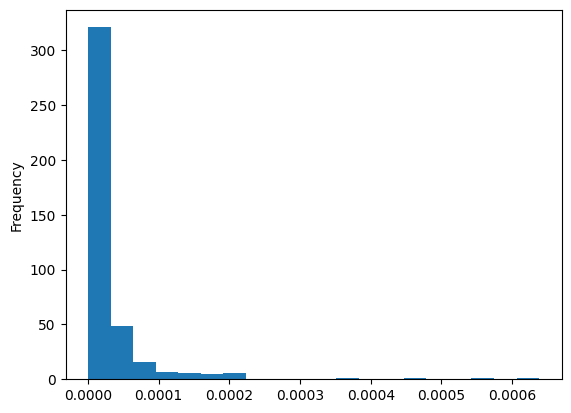

In [138]:
county_hate_rates_df["hate_crime_rate"].plot.hist(bins=20)

In [154]:
county_hate_rates_df.dtypes

hate_crime_count                                                                                                                                               int64
pug_agency_name                                                                                                                                               object
Geography                                                                                                                                                     object
Geographic Area Name                                                                                                                                          object
Total population                                                                                                                                             float64
Male                                                                                                                                                          object
Female    

##Perform power transformations and normalize data

In [140]:
def transform_standardize_data(df, numerical_cols):
  # use yeo-johnson since there's some negative data, box-cox only works on positive data, and I'm too lazy to write the extra lines of code
  transformer = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)

  # add a slight offset to the data since the power transformer was getting mad at a bunch of values being the same
  shifted_data = df[numerical_cols] - df[numerical_cols].min().min() + 1e-6

  transformed_data = transformer.fit_transform(shifted_data)

  # add the transformed, standardized data back to the original dataframe and update the list of column labels
  for i, col in enumerate(numerical_cols):
    numerical_cols[i] = "transformed_" + col
    df["transformed_" + col] = transformed_data[:, i]

In [157]:
crime_numerical_cols = list(crime_df.select_dtypes(include=['int64', 'float64']).columns)
county_numerical_cols = list(county_demo_df.select_dtypes(include=["int64", "float64"]).columns)
hate_rate_numerical_cols = list(county_hate_rates_df.select_dtypes(include=["int64", "float64"]).columns)

In [48]:
#transform the county data
transform_standardize_data(county_demo_df, county_numerical_cols)

In [49]:
#transform the crime data
transform_standardize_data(crime_df, crime_numerical_cols)

In [158]:
#transform the hate_rate data
transform_standardize_data(county_hate_rates_df, hate_rate_numerical_cols)

In [147]:
county_hate_rates_df.head()

,hate_crime_count,pug_agency_name,Geography,Geographic Area Name,Total population,Male,Female,Sex ratio (males per 100 females),Under 5 years,5 to 9 years,10 to 14 years,15 to 19 years,20 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 59 years,60 to 64 years,65 to 74 years,75 to 84 years,85 years and over,Median age (years),Under 18 years,16 years and over,21 years and over,62 years and over,18 years and over,18 years and over!!Male,18 years and over!!Female,18 years and over!!Sex ratio (males per 100 females),65 years and over,65 years and over!!Male,65 years and over!!Female,65 years and over!!Sex ratio (males per 100 females),RACE!!Total population,RACE!!One race,RACE!!One race!!White,RACE!!One race!!Black or African American,RACE!!One race!!American Indian and Alaska Native,RACE!!One race!!American Indian and Alaska Native!!Cherokee tribal grouping,RACE!!One race!!American Indian and Alaska Native!!Chippewa tribal grouping,RACE!!One race!!American Indian and Alaska Native!!Navajo tribal grouping,RACE!!One race!!American Indian and Alaska Native!!Sioux tribal grouping,RACE!!One race!!Asian,RACE!!One race!!Asian!!Asian Indian,RACE!!One race!!Asian!!Chinese,RACE!!One race!!Asian!!Filipino,RACE!!One race!!Asian!!Japanese,RACE!!One race!!Asian!!Korean,RACE!!One race!!Asian!!Vietnamese,RACE!!One race!!Asian!!Other Asian,RACE!!One race!!Native Hawaiian and Other Pacific Islander,RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Chamorro,RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Native Hawaiian,RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Samoan,RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Other Native Hawaiian and Other Pacific Islander,RACE!!One race!!Some Other Race,RACE!!Two or More Races,RACE!!Two or More Races!!White and Black or African American,RACE!!Two or More Races!!White and American Indian and Alaska Native,RACE!!Two or More Races!!White and Asian,RACE!!Two or More Races!!White and Some Other Race,RACE!!Two or More Races!!Black or African American and American Indian and Alaska Native,RACE!!Two or More Races!!Black or African American and Some Other Race,Race alone or in combination with one or more other races!!Total population,Race alone or in combination with one or more other races!!White,Race alone or in combination with one or more other races!!Black or African American,Race alone or in combination with one or more other races!!American Indian and Alaska Native,Race alone or in combination with one or more other races!!Asian,Race alone or in combination with one or more other races!!Native Hawaiian and Other Pacific Islander,Race alone or in combination with one or more other races!!Some Other Race,HISPANIC OR LATINO AND RACE!!Total population,HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race),HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Mexican,HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Puerto Rican,HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Cuban,HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Other Hispanic or Latino,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!White alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Black or African American alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!American Indian and Alaska Native alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Asian alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Some Other Race alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races!!Two races including Some Other Race,"HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races!!Two races excluding Some Other Race, and three or more races",To

##Merge the datasets

In [52]:
# combine the crime and population datasets
merged_df = pd.merge(crime_df, county_demo_df, on=["pug_agency_name", "agency_type_name", "state_name"])

In [53]:
merged_df.drop(other_unique_categorical_cols["pug_agency_name"] + ["ori", "state_abbr", "population_group_code", "pub_agency_unit",
                "Geography", "Percent!!Total population", "population_group_description",
                "Geographic Area Name", "incident_date", "pub_agency_unit", "pug_agency_name",
                "agency_type_name", "state_name", "division_name", "offender_race", "offender_ethnicity",
                "location_name", "bias_desc", "victim_types", "multiple_offense",
                  "multiple_bias"], axis=1, inplace=True)

# include offense_name in categorical data once you've refactored multicol parsing

#Data Exploration

##Important Functions

In [54]:
def get_sorted_corrs(corr):
  # Unstack and rename corr
  corr_sorted = pd.DataFrame(corr.unstack()).reset_index()
  corr_sorted.rename(columns={"level_0":"feature1", "level_1":"feature2", 0:"corr"}, inplace=True)

  corr_sorted["abs_corr"] = 0

  # Get highest correlation coefficient pairs
  corr_sorted["abs_corr"] = corr_sorted["corr"].abs()
  corr_sorted.sort_values(by="abs_corr", ascending=False, inplace=True)

  #reset the indices
  corr_sorted.reset_index(inplace=True)

  #filter out self-correlations
  corr_sorted = corr_sorted[~(corr_sorted["feature1"] == corr_sorted["feature2"])]

  # remove duplicates
  # only keep even-numbered rows, since there will be 2 of every correlation
  corr_sorted = corr_sorted.iloc[::2]
  # corr_sorted = corr_sorted.dropna().groupby("feature1")

  return corr_sorted

In [55]:
def do_corr_analysis(corr, minThreshold, maxThreshold, blacklistPhraseRegex, corr_sorted=None):
    # get the sorted correlation coefficients
    if corr_sorted is None:
      sorted_corrs = get_sorted_corrs(crime_corr)
    else:
      sorted_corrs = corr_sorted

    # create subplot display
    fig, ax = plt.subplots(3, figsize=(10, 10))

    # plot stuff
    sorted_corrs["corr"].plot.hist(bins=40, logy=True, ax=ax[0], title="Correlation Coefficients")
    sorted_corrs["abs_corr"].plot.hist(bins=40, logy=True, ax=ax[1], title="Correlation Coefficients' Absolute Values")

    # filter down to correlations of interest
    corrs_of_interest = sorted_corrs[(sorted_corrs["abs_corr"] > minThreshold) & (sorted_corrs["abs_corr"] < maxThreshold)
                                      & (~sorted_corrs["feature1"].str.contains(blacklistPhraseRegex))
                                      & (~sorted_corrs["feature2"].str.contains(blacklistPhraseRegex))]

    # plot the remaining correlations
    corrs_of_interest["corr"].plot.hist(bins=40, logy=True, ax=ax[2], title="Correlation Coefficients of Interest")

    return sorted_corrs, corrs_of_interest

##Individual Datasets

###Hate Crime Dataset

In [56]:
crime_df.head()

index  incident_id  data_year        ori pug_agency_name pub_agency_unit  \
0  230026      1433145       2022  AL0020000          Mobile             NaN   
1  230031      1433182       2022  AL0010000       Jefferson             NaN   
2  230032      1433188       2022  AL0010000       Jefferson             NaN   
3  230038      1465987       2022  AL0620000      Tallapoosa             NaN   
4  230041      1466003       2022  AL0290000          Elmore             NaN   

  agency_type_name state_abbr state_name       division_name region_name  \
0           County         AL    Alabama  East South Central       South   
1           County         AL    Alabama  East South Central       South   
2           County         AL    Alabama  East South Central       South   
3           County         AL    Alabama  East South Central       South   
4           County         AL    Alabama  East South Central       South   

  population_group_code              population_group_description  \
0                    9A              MSA counties 100,000 or over   
1                    9A              MSA counties 100,000 or over   
2                    9A              MSA counties 100,000 or over   
3                    8C  Non-MSA counties from 10,000 thru 24,999   
4                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2022-03-11                 1.0                    0.0   
1    2022-02-06                 1.0                    0.0   
2    2022-03-03                 1.0                    0.0   
3    2022-01-04                 1.0                    0.0   
4    2022-02-14                 1.0                    0.0   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     2                   2.0                      0.0   
1                     2                   2.0                      0.0   
2                     2                   2.0                      0.0   
3                     1                   1.0                      0.0   
4                     0                   NaN                      NaN   

               offender_race      offender_ethnicity  victim_count  \
0                      White  Not Hispanic or Latino             1   
1                    Unknown           Not Specified             1   
2  Black or African American  Not Hispanic or Latino             1   
3  Black or African American  Not Hispanic or Latino             1   
4              Not Specified           Not Specified             1   

                   offense_name  total_individual_victims  \
0                Simple Assault                       1.0   
1           Theft From Building                       1.0   
2                  Intimidation                       1.0   
3            Aggravated Assault                       1.0   
4  Burglary/Breaking & Entering                       1.0   

                                   location_name  \
0                                 Residence/Home   
1                                 Residence/Home   
2                        Parking/Drop Lot/Garage   
3  Jail/Prison/Penitentiary/Corrections Facility   
4                                 Residence/Home   

                                   bias_desc victim_types multiple_offense  \
0  Anti-Asian;Anti-Black or African American   Individual                S   
1         Anti-Other Race/Ethnicity/Ancestry   Individual                S   
2                            Anti-Gay (Male)   Individual                S   
3                                 Anti-White   Individual                S   
4                                  Anti-Sikh   Individual                S   

  multiple_bias  incident_month  incident_day  \
0             M               3            11   
1             S               2             6   
2             S               3             3   
3             S               1             4   
4             S   

####Correlation matrix

In [57]:
for item in ['level_0', 'index', 'incident_id', 'data_year']:
  if item in crime_numerical_cols:
    crime_numerical_cols.remove(item)

In [58]:
# Create a correlation matrix
crime_corr = crime_df[crime_numerical_cols].dropna().corr()

In [95]:
# Set the figure size
plt.figure(figsize=(200, 100))

# Create a heatmap of the correlation matrix
sns.heatmap(crime_corr, annot=True)

# Show the plot
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f9e7e911000> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f9e7e910280> (for post_execute):


KeyboardInterrupt: 

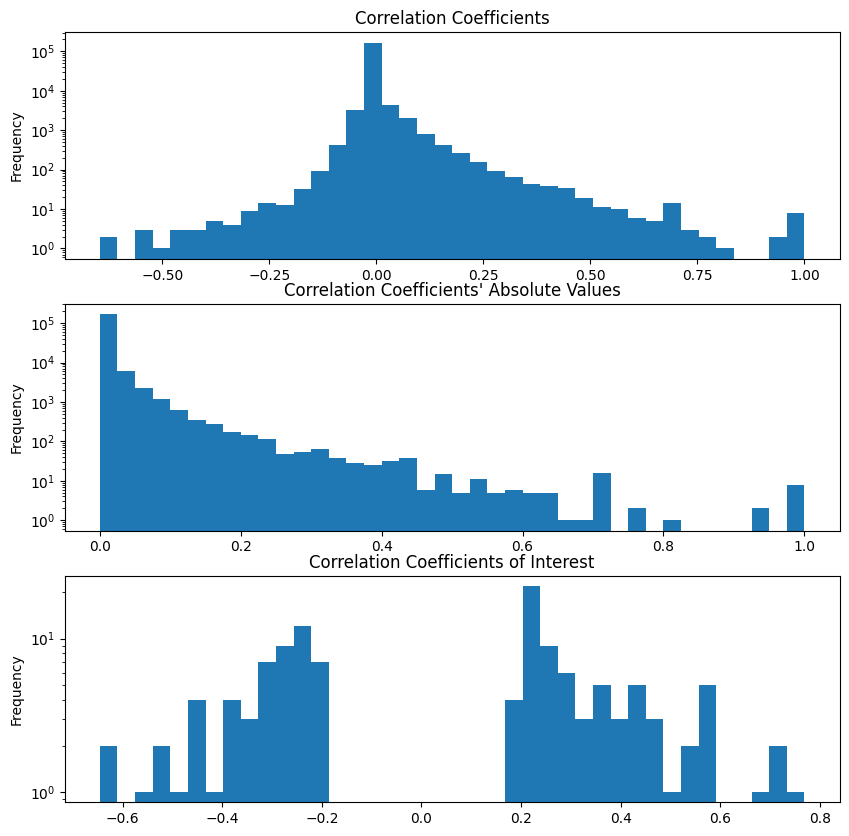

In [96]:
sorted_crime_corrs, crime_corrs_of_interest = do_corr_analysis(crime_corr, 0.2, 0.9, "pug_agency_name|state_name")

In [97]:
crime_corrs_of_interest

,index,feature1,feature2,corr,abs_corr
621,66205,transformed_location_name_Church/Synagogue/Tem...,transformed_victim_types_Religious Organization,0.769083,0.769083
627,6141,transformed_total_individual_victims,transformed_adult_victim_count,0.714344,0.714344
629,6186,transformed_total_individual_victims,transformed_victim_types_Individual,0.712022,0.712022
659,42336,transformed_offense_name_Drug/Narcotic Violations,transformed_victim_types_Society/Public,0.664949,0.664949
661,4780,transformed_juvenile_offender_count,transformed_adult_offender_count,-0.645931,0.645931
673,430285,transformed_offender_race_White,transformed_offender_race_Black or African Ame...,-0.612630,0.612630
685,82542,transformed_location_name_Rental Storage Facility,transformed_bias_desc_Anti-Church of Jesus Christ,0.576842,0.576842
687,19869,transformed_bias_desc_Anti-Jehovah's Witness,transformed_location_name_Amusement Park,0.576842,0.576842
695,6146,transformed_total_individual_victims,transformed_victim_count,0.565622,0.565622
697,4778,transformed_juvenile_offender_count,transformed_juvenile_victim_count,0.561248,0.561248


####Quantitative variable figures

In [ ]:
crime_df['total_offender_count'].plot.hist(bins=14, title='total_offender_count', logy=True)

In [ ]:
crime_df['adult_victim_count'].plot.hist(bins=15, title='adult_victim_count', logy=True)

In [ ]:
crime_df['juvenile_victim_count'].plot.hist(bins=10, title='juvenile_victim_count', logy=True)

####Categorical variable figures


In [ ]:
def plot_column_counts(df, column_name, unique_values, title_phrase, figsize=(20, 5), rotation=90):
    # Create a dictionary of unique values and their counts
    unique_value_counts = get_col_counts(df, unique_values)

    # Sort the dictionary by values in descending order
    sorted_value_counts = dict(sorted(unique_value_counts.items(), key=lambda item: item[1], reverse=True))

    # Create a bar chart of the sorted valuees and their counts
    plt.figure(figsize=figsize)
    sns.barplot(x=list(sorted_value_counts.keys()), y=list(sorted_value_counts.values()), log=True)

    # Set the title and labels
    plt.title("Frequency of " + title_phrase + " in Hate Crimes", fontsize=16)
    plt.xlabel(title_phrase, fontsize=14)
    plt.ylabel("Frequency (Log Scale)", fontsize=14)

    # Rotate the x-axis labels for readability
    plt.xticks(rotation=rotation)

    # Show the plot
    plt.show()


In [ ]:
crime_df.groupby('region_name').size().sort_values(ascending=False).plot.bar(color=sns.palettes.mpl_palette('Dark2'))
plt.xticks(rotation=0)

In [ ]:
crime_df.groupby('offender_race').size().sort_values(ascending=True).plot.barh(color=sns.palettes.mpl_palette('Dark2'), figsize=(10,10), logx=True)

In [ ]:
plot_column_counts(crime_df, "bias_desc", bias_cols, "Biases")

In [ ]:
figsize=(20, 5)
plot_column_counts(crime_df, "victim_types", victim_cols, "Victims", figsize, 0)

In [ ]:
plot_column_counts(crime_df, "offense_name", offense_cols, "Offenses")

In [ ]:
plot_column_counts(crime_df, "location_names", location_cols, "Locations")

####Geographic heat maps

In [ ]:
ignore_list = ["Not Specified", "Unknown", "Multiple"]

In [ ]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['offender_race'].value_counts()
    for x_label, grp in crime_df.groupby('region_name')
})

# Drop less relevant columns for easier comparison with victim race heatmap
for item in ignore_list:
  df_2dhist.drop(item, inplace=True)

# Apply logarithmic transformation to the counts
df_2dhist_log = df_2dhist.applymap(lambda x: 0 if x == 0 else np.log10(x))

sns.heatmap(df_2dhist_log, cmap='viridis')
plt.title("Logarithmic Frequency of Offender Races by Region")
plt.xlabel("Region Name")
plt.ylabel("Offender Race")

In [ ]:
# Get some victim races to start with
unique_offender_races = crime_df['offender_race'].unique().tolist()

# Drop categories absent from victim data
for item in ignore_list:
  unique_offender_races.remove(item)

unique_victim_races = ["bias_desc_Anti-" + str(race) for race in unique_offender_races]

print(unique_victim_races)

In [ ]:
plt.subplots(figsize=(8, 8))

# Initialize an empty DataFrame with the correct index and columns
df_2dhist = pd.DataFrame(index=unique_victim_races, columns=crime_df['region_name'].unique())

# Iterate over each region and calculate the value counts for each victim race
for region in df_2dhist.columns:
    region_data = crime_df[crime_df['region_name'] == region]

    for victim_race in unique_victim_races:
        # Sum of occurrences of victim_race in the region
        count = region_data[victim_race].sum()
        # Update the DataFrame cell with the count
        df_2dhist.loc[victim_race, region] = count

# Convert DataFrame entries to numeric type and drop nan values
df_2dhist = df_2dhist.apply(pd.to_numeric)

# Apply logarithmic transformation to the counts
df_2dhist = df_2dhist.applymap(lambda x: 0 if x == 0 else np.log10(x))

# Create the heatmap with logarithmic scale
sns.heatmap(df_2dhist, cmap='viridis')

# Give the plot a title and axis labels
plt.title("Logarithmic Frequency of Victim Races by Region")
plt.xlabel("Region Name")
plt.ylabel("Victim Races")
plt.yticks(rotation=0)

plt.show()

###County Demographics Dataset

In [ ]:
county_demo_df.head()

####Correlation matrix

In [ ]:
county_numerical_cols = list(county_demo_df.select_dtypes(include=["int64", "float64"]).columns)

In [ ]:
# Create a correlation matrix
county_corr = county_demo_df[county_numerical_cols].corr()

In [ ]:
# Set the figure size
plt.figure(figsize=(100, 50))

# Create a heatmap of the correlation matrix
sns.heatmap(county_corr, annot=True)

# Show the plot
plt.show()

In [ ]:
sorted_county_corrs, county_corrs_of_interest = do_corr_analysis(county_corr, 0.2, 0.9, "pug_agency_name|state_name")

In [ ]:
county_corrs_of_interest

####Other figures

In [ ]:
county_demo_df.plot.scatter(x='Under 5 years', y='85 years and over', logx=True, logy=True, s=40, alpha=.8, figsize=(16,8))

In [ ]:
county_demo_df[age_groups].mean().plot.bar(figsize=(20,5))
plt.xlabel('Age Group')
plt.ylabel('Mean Population')
plt.title('Mean Population by Age Group in City Demographics')
plt.xticks(rotation=0)
plt.show()

In [ ]:
county_hate_rates_df["hate_crime_count"].sort_values(ascending=True).plot.barh(logx=True, figsize=(10, 100))

##Merged Datasets

###Primary Merged Dataset

In [ ]:
merged_df.head()

####Correlation Matrix Analysis

In [99]:
#convert the categorical columns to numerical ones and store the modified df as a new df for correlation analysis
categorical_to_int_df = merged_df\
                          .select_dtypes(include=['int64', 'float64', np.number])\
                          .drop(labels=["index", "incident_id"], axis=1)
# Select only the numerical columns
numerical_cols = [col for col in categorical_to_int_df.columns if "transformed_" in col]
# numerical_cols

In [100]:
# Create a correlation matrix
merged_corr = merged_df[numerical_cols].corr()

In [101]:
merged_corr_sorted = get_sorted_corrs(merged_corr)
merged_corr_sorted.head()

,index,feature1,feature2,corr,abs_corr
0,510970,transformed_state_name_Idaho,transformed_pug_agency_name_Ada,1.0,1.0
97,354694,transformed_pug_agency_name_Pennington,transformed_state_name_South Dakota,1.0,1.0
284,563086,transformed_Percent!!Total population,transformed_Percent!!Race alone or in combinat...,1.0,1.0
287,563002,transformed_Percent!!Total population,transformed_Total population,1.0,1.0
313,556714,transformed_18 years and over,transformed_Percent!!18 years and over,1.0,1.0


In [102]:
# remove coefficients that represent variables' correlations with themselves
#   and remove feature correlations with other features from the same set (which were reviewed in the individual dataset explorations above)
county_cols = list(county_numerical_cols)
crime_cols = list(crime_numerical_cols)

merged_corr_sorted = merged_corr_sorted[~(
    ((merged_corr_sorted["feature1"].isin(county_cols))
      & (merged_corr_sorted["feature2"].isin(county_cols)))
    | ((merged_corr_sorted["feature1"].isin(crime_cols))
      & (merged_corr_sorted["feature2"].isin(crime_cols)))
)]

In [103]:
merged_corr_sorted.head()

,index,feature1,feature2,corr,abs_corr
561,362687,transformed_pug_agency_name_Pinal,transformed_Percent!!RACE!!One race!!American ...,1.000000,1.000000
1593,605289,transformed_Percent!!RACE!!Two or More Races!!...,transformed_pug_agency_name_Charles,0.885038,0.885038
1601,509241,transformed_state_name_Florida,transformed_Percent!!HISPANIC OR LATINO AND RA...,0.873447,0.873447
1643,606281,transformed_Percent!!RACE!!Two or More Races!!...,transformed_pug_agency_name_Miami-Dade,0.810938,0.810938
1697,593709,transformed_Percent!!RACE!!One race!!Asian!!Ja...,transformed_pug_agency_name_San Mateo,0.731543,0.731543


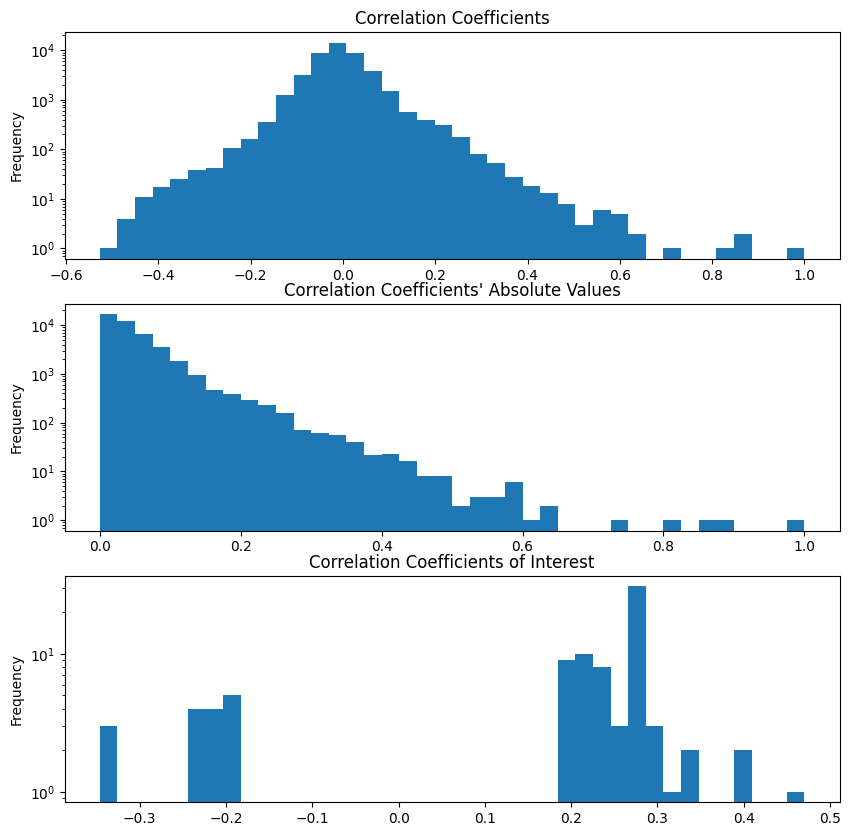

In [108]:
# drop half the entries, which are essentially duplicates,
#   as well as any np.nan entries and entries with low correlation coefficients or exceedingly high correlation coefficients,
#   which have already been considered previously or present trivial correlation information
#   (ie the number of individuals under 5 years of age is directly correlated with the total population)
merged_corr_sorted, merged_corrs_of_interest = do_corr_analysis(merged_corr, 0.2, 1, "state_name|division_name|pug_agency_name|index|incident_id", merged_corr_sorted)

In [107]:
merged_corrs_of_interest

,index,feature1,feature2,corr,abs_corr
3419,621838,transformed_Percent!!HISPANIC OR LATINO AND RA...,transformed_location_name_Other/Unknown,0.470472,0.470472
4143,40385,transformed_victim_types_Other,transformed_Percent!!HISPANIC OR LATINO AND RA...,0.396573,0.396573
4185,94206,transformed_location_name_Other/Unknown,transformed_Percent!!RACE!!One race!!Asian!!Ko...,0.391592,0.391592
4699,613918,transformed_Percent!!HISPANIC OR LATINO AND RA...,transformed_location_name_Other/Unknown,-0.346271,0.346271
4733,498918,transformed_offender_race_Unknown,transformed_Percent!!RACE!!One race!!Asian!!Ko...,0.343775,0.343775
4767,24545,transformed_bias_desc_Anti-Jewish,transformed_Percent!!HISPANIC OR LATINO AND RA...,0.341549,0.341549
4931,94244,transformed_location_name_Other/Unknown,transformed_Percent!!HISPANIC OR LATINO AND RA...,-0.333981,0.333981
5015,502903,transformed_offender_ethnicity_Not Specified,transformed_Percent!!HISPANIC OR LATINO AND RA...,-0.330865,0.330865
5315,594050,transformed_Percent!!RACE!!One race!!Asian!!Ko...,transformed_victim_types_Other,0.313028,0.313028
5615,498864,transformed_offender_race_Unknown,transformed_85 years and over,0.299846,0.299846


####Other Figures

In [ ]:
#blah

###County Feature Prediction Dataset

In [148]:
county_hate_rates_df.head()

,hate_crime_count,pug_agency_name,Geography,Geographic Area Name,Total population,Male,Female,Sex ratio (males per 100 females),Under 5 years,5 to 9 years,10 to 14 years,15 to 19 years,20 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 59 years,60 to 64 years,65 to 74 years,75 to 84 years,85 years and over,Median age (years),Under 18 years,16 years and over,21 years and over,62 years and over,18 years and over,18 years and over!!Male,18 years and over!!Female,18 years and over!!Sex ratio (males per 100 females),65 years and over,65 years and over!!Male,65 years and over!!Female,65 years and over!!Sex ratio (males per 100 females),RACE!!Total population,RACE!!One race,RACE!!One race!!White,RACE!!One race!!Black or African American,RACE!!One race!!American Indian and Alaska Native,RACE!!One race!!American Indian and Alaska Native!!Cherokee tribal grouping,RACE!!One race!!American Indian and Alaska Native!!Chippewa tribal grouping,RACE!!One race!!American Indian and Alaska Native!!Navajo tribal grouping,RACE!!One race!!American Indian and Alaska Native!!Sioux tribal grouping,RACE!!One race!!Asian,RACE!!One race!!Asian!!Asian Indian,RACE!!One race!!Asian!!Chinese,RACE!!One race!!Asian!!Filipino,RACE!!One race!!Asian!!Japanese,RACE!!One race!!Asian!!Korean,RACE!!One race!!Asian!!Vietnamese,RACE!!One race!!Asian!!Other Asian,RACE!!One race!!Native Hawaiian and Other Pacific Islander,RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Chamorro,RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Native Hawaiian,RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Samoan,RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Other Native Hawaiian and Other Pacific Islander,RACE!!One race!!Some Other Race,RACE!!Two or More Races,RACE!!Two or More Races!!White and Black or African American,RACE!!Two or More Races!!White and American Indian and Alaska Native,RACE!!Two or More Races!!White and Asian,RACE!!Two or More Races!!White and Some Other Race,RACE!!Two or More Races!!Black or African American and American Indian and Alaska Native,RACE!!Two or More Races!!Black or African American and Some Other Race,Race alone or in combination with one or more other races!!Total population,Race alone or in combination with one or more other races!!White,Race alone or in combination with one or more other races!!Black or African American,Race alone or in combination with one or more other races!!American Indian and Alaska Native,Race alone or in combination with one or more other races!!Asian,Race alone or in combination with one or more other races!!Native Hawaiian and Other Pacific Islander,Race alone or in combination with one or more other races!!Some Other Race,HISPANIC OR LATINO AND RACE!!Total population,HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race),HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Mexican,HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Puerto Rican,HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Cuban,HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Other Hispanic or Latino,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!White alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Black or African American alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!American Indian and Alaska Native alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Asian alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Some Other Race alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races!!Two races including Some Other Race,"HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races!!Two races excluding Some Other Race, and three or more races",To

####Correlation Analysis

In [198]:
hate_rate_corr = county_hate_rates_df[hate_rate_numerical_cols].corr()

In [190]:
hate_rate_corr.head()

,transformed_hate_crime_count,transformed_Total population,transformed_Sex ratio (males per 100 females),transformed_Under 5 years,transformed_5 to 9 years,transformed_10 to 14 years,transformed_15 to 19 years,transformed_20 to 24 years,transformed_25 to 34 years,transformed_35 to 44 years,transformed_45 to 54 years,transformed_55 to 59 years,transformed_60 to 64 years,transformed_65 to 74 years,transformed_75 to 84 years,transformed_85 years and over,transformed_Median age (years),transformed_Under 18 years,transformed_16 years and over,transformed_21 years and over,transformed_62 years and over,transformed_18 years and over,transformed_18 years and over!!Male,transformed_18 years and over!!Female,transformed_18 years and over!!Sex ratio (males per 100 females),transformed_65 years and over,transformed_65 years and over!!Male,transformed_65 years and over!!Female,transformed_65 years and over!!Sex ratio (males per 100 females),transformed_Percent!!Total population,transformed_Percent!!Male,transformed_Percent!!Female,transformed_Percent!!Under 5 years,transformed_Percent!!5 to 9 years,transformed_Percent!!10 to 14 years,transformed_Percent!!15 to 19 years,transformed_Percent!!20 to 24 years,transformed_Percent!!25 to 34 years,transformed_Percent!!35 to 44 years,transformed_Percent!!45 to 54 years,transformed_Percent!!55 to 59 years,transformed_Percent!!60 to 64 years,transformed_Percent!!65 to 74 years,transformed_Percent!!75 to 84 years,transformed_Percent!!85 years and over,transformed_Percent!!Under 18 years,transformed_Percent!!16 years and over,transformed_Percent!!21 years and over,transformed_Percent!!62 years and over,transformed_Percent!!18 years and over,transformed_Percent!!18 years and over!!Male,transformed_Percent!!18 years and over!!Female,transformed_Percent!!65 years and over,transformed_Percent!!65 years and over!!Male,transformed_Percent!!65 years and over!!Female,transformed_Percent!!RACE!!Total population,transformed_Percent!!RACE!!One race,transformed_Percent!!RACE!!One race!!White,transformed_Percent!!RACE!!One race!!Black or African American,transformed_Percent!!RACE!!One race!!American Indian and Alaska Native,transformed_Percent!!RACE!!One race!!American Indian and Alaska Native!!Cherokee tribal grouping,transformed_Percent!!RACE!!One race!!American Indian and Alaska Native!!Chippewa tribal grouping,transformed_Percent!!RACE!!One race!!American Indian and Alaska Native!!Navajo tribal grouping,transformed_Percent!!RACE!!One race!!American Indian and Alaska Native!!Sioux tribal grouping,transformed_Percent!!RACE!!One race!!Asian,transformed_Percent!!RACE!!One race!!Asian!!Asian Indian,transformed_Percent!!RACE!!One race!!Asian!!Chinese,transformed_Percent!!RACE!!One race!!Asian!!Filipino,transformed_Percent!!RACE!!One race!!Asian!!Japanese,transformed_Percent!!RACE!!One race!!Asian!!Korean,transformed_Percent!!RACE!!One race!!Asian!!Vietnamese,transformed_Percent!!RACE!!One race!!Asian!!Other Asian,transformed_Percent!!RACE!!One race!!Native Hawaiian and Other Pacific Islander,transformed_Percent!!RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Chamorro,transformed_Percent!!RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Native Hawaiian,transformed_Percent!!RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Samoan,transformed_Percent!!RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Other Native Hawaiian and Other Pacific Islander,transformed_Percent!!RACE!!One race!!Some Other Race,transformed_Percent!!RACE!!Two or More Races,transformed_Percent!!RACE!!Two or More Races!!White and Black or African American,transformed_Percent!!RACE!!Two or More Races!!White and American Indian and Alaska Native,transformed_Percent!!RACE!!Two or More Races!!White and Asian,transformed_Percent!!RACE!!Two or More Races!!White and Some Other Race,transformed_Percent!!RACE!!Two or More Races!!Black or African American and American Indian and Alaska Native,transformed_Percent!!RAC

In [161]:
# Set the figure size
plt.figure(figsize=(100, 50))

# Create a heatmap of the correlation matrix
sns.heatmap(hate_rate_corr, annot=True)

# Show the plot
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f9e7e910280> (for post_execute):


KeyboardInterrupt: 

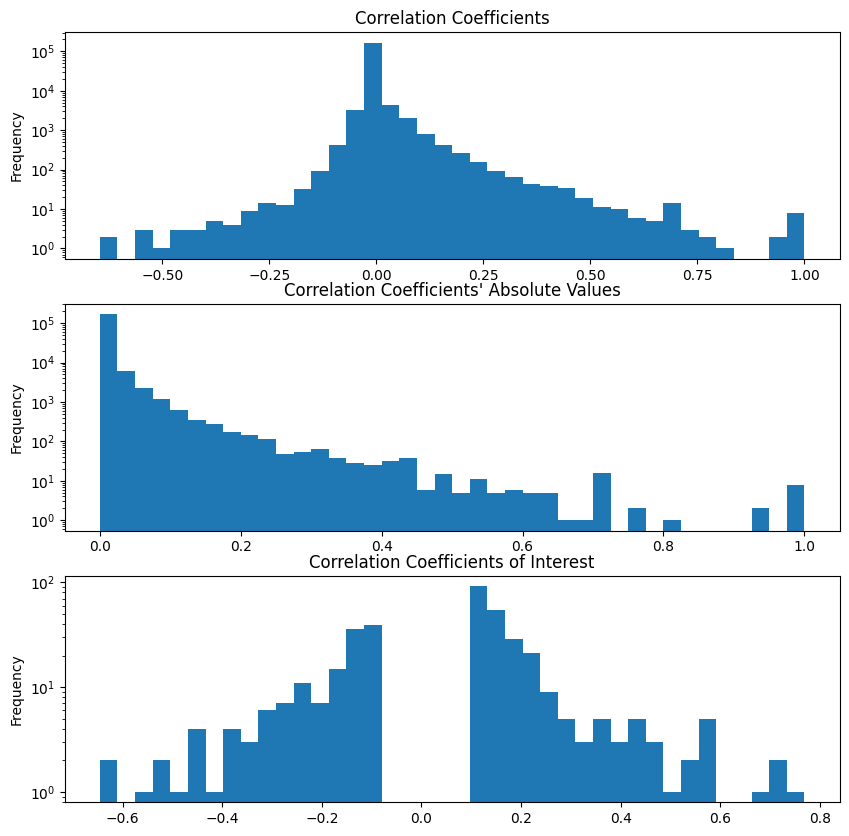

In [203]:
extracted_sorted_corrs, extracted_corrs_of_interest = do_corr_analysis(hate_rate_corr["transformed_hate_crime_rate"], 0.1, 1.01, "state_name|division_name|pug_agency_name")

In [204]:
extracted_corrs_of_interest

,index,feature1,feature2,corr,abs_corr
621,66205,transformed_location_name_Church/Synagogue/Tem...,transformed_victim_types_Religious Organization,0.769083,0.769083
627,6141,transformed_total_individual_victims,transformed_adult_victim_count,0.714344,0.714344
629,6186,transformed_total_individual_victims,transformed_victim_types_Individual,0.712022,0.712022
659,42336,transformed_offense_name_Drug/Narcotic Violations,transformed_victim_types_Society/Public,0.664949,0.664949
661,4780,transformed_juvenile_offender_count,transformed_adult_offender_count,-0.645931,0.645931
673,430285,transformed_offender_race_White,transformed_offender_race_Black or African Ame...,-0.612630,0.612630
685,82542,transformed_location_name_Rental Storage Facility,transformed_bias_desc_Anti-Church of Jesus Christ,0.576842,0.576842
687,19869,transformed_bias_desc_Anti-Jehovah's Witness,transformed_location_name_Amusement Park,0.576842,0.576842
695,6146,transformed_total_individual_victims,transformed_victim_count,0.565622,0.565622
697,4778,transformed_juvenile_offender_count,transformed_juvenile_victim_count,0.561248,0.561248


In [202]:
# look at just the correlations between the hate crime rate and other features
hate_rate_corr.loc["transformed_hate_crime_rate"].sort_values(ascending=False)

transformed_hate_crime_rate                                                                                                                                              1.000000
transformed_transformed_hate_crime_rate                                                                                                                                  0.584610
transformed_hate_crime_count                                                                                                                                             0.469269
transformed_transformed_hate_crime_count                                                                                                                                 0.408512
transformed_transformed_Percent!!RACE!!One race                                                                                                                          0.224222
transformed_Percent!!RACE!!One race                                                                           